In [1]:
import pandas as pd
import numpy as np
import preprocessor as p

def readData(header,splitter,path,columnNo,cols):
    df = pd.DataFrame(pd.read_csv(path, 
                 names=[header], encoding="utf8"))
    df = df[header].str.split(splitter, n = columnNo, expand = True) 
    df.columns = cols
    return df
    
df = readData('Tweet index\tLabel\tTweet text',"\t",
              r"C:\Users\Krishanthy\Documents\MSc\Semi_6\ML\Project\DataFilesV1\train.csv",2,
              ['tweet_index', 'label', 'tweet_text'])
df.head()

,tweet_index,label,tweet_text
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,2,"""I can't breathe!"" was chosen as the most nota..."


In [2]:
df.shape

(3834, 3)

In [3]:
df.label.value_counts()

0    1923
1    1390
2     316
3     205
Name: label, dtype: int64

In [4]:
df.label.value_counts().plot(kind='bar')

In [5]:
#preprocessing tweet text
def preprocessing(texts,labels):
    columns = ['text','mentions','hashtags','emojis','smilies','label']
    data = []

    i = 0
    for tweet in texts:
        parse_tweet = p.parse(tweet)
        
        mentions = ''
        hashtags = ''
        emojis = ''
        smilies = ''
        
        if parse_tweet.mentions is None:
            mentions = None
        else:
            for mention in parse_tweet.mentions:
                mentions = mentions + mention.match + ","
        
        if parse_tweet.hashtags is None:
            hashtags = None
        else:
            for hashtag in parse_tweet.hashtags:
                hashtags = hashtags + hashtag.match + ","
        
        if parse_tweet.emojis is None:
            emojis = None
        else:
            for emoji in parse_tweet.emojis:
                emojis = emojis + emoji.match
        
        if parse_tweet.smileys is None:
            smilies = None
        else:
            for smilie in parse_tweet.smileys:
                smilies = smilies + smilie.match + ' '
        
        if labels is None:
            label = '?'
        else:
            label = labels[i]
        
        row = [p.clean(tweet),mentions,hashtags,emojis,smilies,label]
        data.append(row)
        i = i+1
    df1 = pd.DataFrame(data, columns=columns)
    return df1

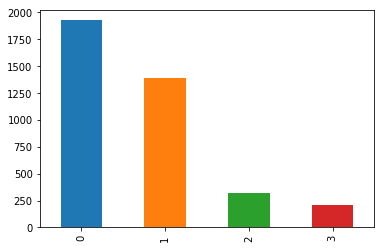

In [6]:
df1 = preprocessing(df.tweet_text,df.label)
df1.label.value_counts().plot(kind='bar')

,tweet_index,label,tweet_text
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
5,6,0,You're never too old for Footie Pajamas. http:...


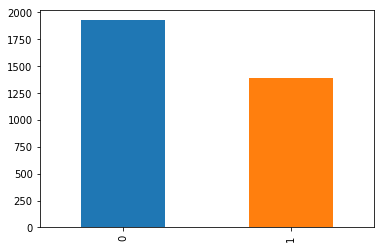

In [12]:
#removing unwanted labels (2 and 3 are not wanted )
df1 = df[(df.label == '0') | (df.label == '1')]
df1.label.value_counts().plot(kind='bar')
df1.head()

In [17]:
from keras.utils import to_categorical
X = df.tweet_text
Y = df.label

##Preprocessing test data
test_df = pd.DataFrame(pd.read_csv(r"C:\Users\Krishanthy\Documents\MSc\Semi_6\ML\Project\DataFilesV1\test.csv", 
                 names=['tweet_index','tweet_text'], encoding="utf8"))

test_df = test_df.iloc[1:]

test_X = test_df.tweet_text

In [18]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [19]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open(r'C:\Users\Krishanthy\Documents\MSc\Semi_6\ML\Project\wiki-news-300d-1M.vec',encoding="utf-8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
    
#cach embedding_index later

In [21]:
# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(df.tweet_text)
token.fit_on_texts(test_X)
word_index = token.word_index

In [22]:
# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(test_X), maxlen=70)

In [23]:
# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [24]:
print (embedding_matrix[0:5])

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.0897      0.016      -0.0571     ...  0.1559     -0.0254
  -0.0259    ]
 [ 0.0157     -0.0748     -0.0862     ...  0.189      -0.0433
  -0.1014    ]
 [ 0.0495      0.0411      0.0041     ...  0.23710001 -0.0298
  -0.0284    ]
 [ 0.0047      0.0223     -0.0087     ...  0.1479      0.13240001
  -0.0318    ]]


In [25]:
import tensorflow as tf

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    new_prediction = []
    if is_neural_net:
        predictions = tf.math.argmax(tf.nn.softmax(predictions),axis=1)
    
    #for i in predictions:
     #   if predictions[i] > 0.4:
      #      new_prediction[i] = 1
       # else:
        #    new_prediction[i] = 0 
    
    #print (new_prediction)
    
    return predictions

In [26]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

In [27]:
classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x,  Y, valid_seq_x, is_neural_net=False)
print ('accuracy::::')
print (accuracy)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/1
3834/3834 [==============================] - 3s 877us/step - loss: 0.2471
accuracy::::
[[0.3985942 ]
 [0.99999964]
 [0.07120648]
 [0.69463885]
 [0.9999989 ]
 [0.9896338 ]
 [0.9999989 ]
 [0.9936312 ]
 [0.53764886]
 [0.79982656]
 [0.1702511 ]
 [0.14034237]
 [0.9999989 ]
 [0.7205918 ]
 [0.7567968 ]
 [0.8111466 ]
 [0.6725958 ]
 [0.85394794]
 [0.91272193]
 [0.99999857]
 [0.9999988 ]
 [0.9999989 ]
 [0.99999785]
 [0.99999964]
 [0.39796636]
 [0.99999857]
 [0.8564205 ]
 [0.9999989 ]
 [0.6275652 ]
 [0.10920317]
 [0.4167651 ]
 [0.9999999 ]
 [0.49595714]
 [0.15355068]
 [0.19758081]
 [0.7241873 ]
 [0.16394056]
 [0.2707556 ]
 [0.9300372 ]
 [0.78873765]
 [0.99999917]
 [0.99999964]
 [0.6114815 ]
 [0.6995054 ]
 [0.73576325]
 [0.799873  ]
 [0.80494654]
 [0.99999905]
 [0.6781821 ]
 [0.24650392]
 [0.9999995 ]
 [0.13798346]
 [0.81539565]
 [0.58785576]
 [0.7300966 ]
 [0.69888514]
 [0.14878902]
 [0.9999993 ]
 [0.6492961 ]
 [0.2

In [28]:
for i in accuracy:
    if i[0] > 0.8:
        print (1)
    else:
        print (0)

0
1
0
0
1
1
1
1
0
0
0
0
1
0
0
1
0
1
1
1
1
1
1
1
0
1
1
1
0
0
0
1
0
0
0
0
0
0
1
0
1
1
0
0
0
0
1
1
0
0
1
0
1
0
0
0
0
1
0
0
0
0
1
1
0
1
0
1
0
0
0
1
1
0
1
1
0
0
1
0
0
0
0
1
1
0
1
1
0
1
0
0
0
0
1
0
0
0
1
0
1
0
0
1
0
1
1
0
0
1
0
0
0
0
1
1
0
1
0
1
0
0
1
0
0
1
1
1
1
0
1
1
1
1
0
0
0
0
1
0
0
0
1
1
0
1
0
1
0
0
1
0
0
1
0
1
1
0
1
0
0
0
1
0
0
1
0
1
1
0
1
0
1
1
1
0
0
1
1
0
1
1
0
0
0
0
0
1
1
1
1
1
1
1
1
0
1
0
1
1
0
0
0
1
0
0
0
1
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
0
0
0
1
1
0
0
0
1
0
0
1
0
0
0
1
0
1
0
1
1
1
1
1
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
1
1
0
1
0
0
0
0
0
0
1
1
0
0
0
1
0
0
0
1
0
1
1
0
0
0
0
0
0
1
1
0
1
1
1
0
1
0
0
0
0
0
1
0
0
1
1
1
1
1
0
0
1
1
0
0
0
1
0
0
0
0
0
1
1
0
1
1
0
1
0
0
0
0
1
1
0
0
1
0
1
0
0
0
0
0
1
1
0
1
0
1
1
0
1
0
1
0
0
1
1
0
0
0
0
0
0
1
0
1
0
0
1
0
0
0
0
1
0
1
0
0
0
0
0
1
1
0
1
1
0
0
0
0
1
1
0
0
1
0
1
1
0
1
0
0
1
0
1
1
1
1
1
0
0
1
0
1
0
0
1
1
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
1
1
0
0
0
1
1
0
1
0
0
1
0
1
0
1
0
0
1
0
1
0
1
0
0
0
1
1
1
0
0
0
1
0
1
0
0
0
1
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
0
